Masking example

In [1]:
import os
import pydicom
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pathlib import Path
from ipywidgets import interact, interactive
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize

/home/joshy/anaconda3/envs/jupyter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
data_path = '../data/anonymous_sid10113/'
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [5]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.500000
Pixel Spacing (row, col): (0.791016, 0.791016) 


In [7]:
MAX_HU_LUNG= -380
MIN_HU_LUNG= -1500

<class 'numpy.ndarray'> (512, 512)
(512, 512) bool


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

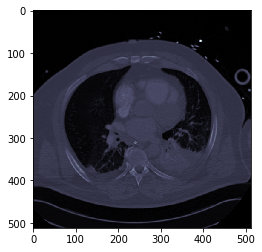

In [8]:
x = imgs[109].copy()
print(type(x), x.shape)
mask = (x >= MIN_HU_LUNG) & (x <= MAX_HU_LUNG)
print(mask.shape, mask.dtype)
plt.imshow(imgs[109], cmap='bone')
mask

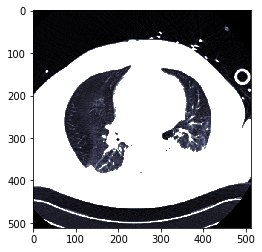

In [9]:
plt.imshow(x*mask, cmap='bone')